# Moon-shaped Classification — Student Tasks

**Goal:** Experiment with neural network architectures on a moon-shaped 2D dataset, compare shallow vs deep models, visualize decision boundaries and analyze how architecture affects learning.

---

## Setup & Learning Objectives

* Create a standard `make_moons` dataset and visualize it.
* Build models with different architectures (shallow vs deep).
* Train models and plot decision boundaries to see how architecture changes the learned classifier.
* Measure performance (accuracy, loss curves) and discuss trade-offs (capacity, overfitting, stability).

---

## Task 1 — Shallow network (one hidden layer, many neurons)

**Description:**
Build a *shallow* fully-connected neural network with a single hidden layer but with many neurons (e.g. 128, 256, or more). Train on the moon dataset and:

* Explore how the number of neurons influences the decision boundary.
* Compare (qualitatively) decision boundary smoothness and overfitting for different neuron counts.

**Things to try:**

* Hidden sizes: `[8, 16, 32, 64, 128, 256]`.
* Activation functions: ReLU, Tanh.

---

## Task 2 — Deeper network (multiple hidden layers)

**Description:**
Build a *deeper* network with multiple smaller hidden layers (e.g. 3–6 layers of size 16–64). Train and:

* Observe how a deeper yet narrower model compares to a shallow wide model in terms of decision boundary complexity and training stability.
* Test combinations of depth and width (e.g. `[64]`, `[32,32]`, `[64,32,16]`, `[128,64,32,16]`).
* Try batch normalization and see its effect on training.

**Things to try:**

* Depth: `1..6` layers.
* Width per layer: `8..256`.
* Activations: ReLU, Tanh.

---

## Shared Evaluation & Visualization

For every model you train:

1. Plot the training and validation loss curves.
2. Plot training and validation accuracy.
3. Plot the decision boundary over the 2D input space.
4. Report final validation accuracy and a short note (2–4 sentences) describing the boundary and likely reasons for the model's behavior.

---

## Starter Python code (PyTorch)

> This starter code creates the moon dataset, defines a flexible MLP class, trains a model, and plots the decision boundary and training history. Use it as the base — change the `hidden_sizes`, `depth`, and hyperparameters to run experiments.

```python
# starter.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons


# ----------------------
# Data creation
# ----------------------
def make_data(n_samples=1000, noise=0.2, random_state=0):
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    return X,y



def plot_decision_boundary(model, scaler, X, y, ax=None, mesh_steps=200, device='cpu'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))
    # prepare grid in original feature space then transform
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, mesh_steps), np.linspace(y_min, y_max, mesh_steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = scaler.transform(grid).astype(np.float32)
    with torch.no_grad():
        logits = model(torch.tensor(grid_scaled).to(device))
        probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
    Z = probs.reshape(xx.shape)
    ax.contourf(xx, yy, Z, levels=20, alpha=0.8)
    ax.scatter(X[:,0], X[:,1], c=y, edgecolor='k', s=35)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title('Decision boundary (probability of class 1)')
    return ax

```

---
---

Good luck — explore, visualize, and have fun seeing how architecture shapes the classifier!


## Task 3 — MNIST Classification with a Vanilla Neural Network

**Objective:** Train a simple fully connected neural network (no CNNs) to classify MNIST digits.

### Steps

1. Load and normalize the MNIST dataset (from `torchvision.datasets.MNIST`).
2. Flatten the 28×28 images to vectors of size 784.
3. Build a simple feed-forward network:

   ```python
   model = MLP([256, 128])  # for example
   ```
4. Train for several epochs, report accuracy on validation/test set.
5. Experiment with depth and width — e.g. `[512]`, `[256,128,64]`, etc.



SOLUTION

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu', use_batchnorm=False):
        super(MLP, self).__init__()
        layers = []

        # Input to first hidden
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_size))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [4]:
def train_model(model, train_loader, val_loader, epochs=100, lr=0.01, device='cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += y_batch.size(0)
            train_correct += (predicted == y_batch).sum().item()

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accs.append(100 * train_correct / train_total)
        val_accs.append(100 * val_correct / val_total)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}] - Train Loss: {train_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.2f}%')

    return train_losses, val_losses, train_accs, val_accs

In [5]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs, title=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss', linewidth=2)
    ax1.plot(val_losses, label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'Loss Curves - {title}', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(train_accs, label='Train Accuracy', linewidth=2)
    ax2.plot(val_accs, label='Val Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title(f'Accuracy Curves - {title}', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_decision_boundary(model, scaler, X, y, title="", mesh_steps=200, device='cpu'):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, mesh_steps),
                         np.linspace(y_min, y_max, mesh_steps))

    # Get predictions
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = scaler.transform(grid).astype(np.float32)

    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(grid_scaled).to(device))
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

    Z = probs.reshape(xx.shape)

    # Plot
    contour = ax.contourf(xx, yy, Z, levels=20, cmap='RdYlBu_r', alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu_r', edgecolor='k', s=40, linewidth=1)
    plt.colorbar(contour, ax=ax, label='P(class=1)')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Feature 1', fontsize=12)
    ax.set_ylabel('Feature 2', fontsize=12)
    ax.set_title(f'Decision Boundary - {title}', fontsize=14)
    plt.tight_layout()
    plt.show()

In [6]:
def prepare_moon_data(n_samples=1000, noise=0.2, random_state=42):
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train_scaled)
    y_train_t = torch.LongTensor(y_train)
    X_val_t = torch.FloatTensor(X_val_scaled)
    y_val_t = torch.LongTensor(y_val)

    # Create data loaders
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return X, y, train_loader, val_loader, scaler

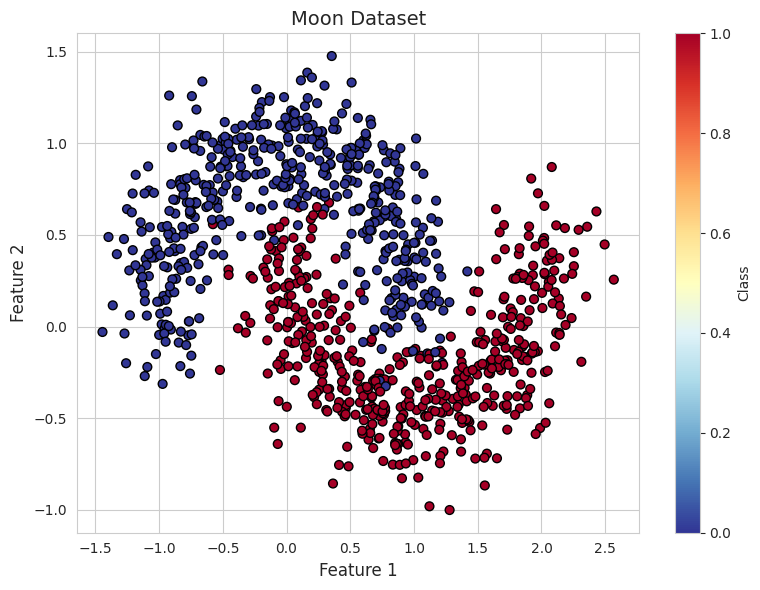


--- Training shallow network with 8 neurons ---
Epoch [20/100] - Train Loss: 0.2540, Val Loss: 0.2775, Val Acc: 86.50%
Epoch [40/100] - Train Loss: 0.2515, Val Loss: 0.2878, Val Acc: 86.00%
Epoch [60/100] - Train Loss: 0.2523, Val Loss: 0.2764, Val Acc: 87.50%
Epoch [80/100] - Train Loss: 0.2506, Val Loss: 0.2773, Val Acc: 86.00%
Epoch [100/100] - Train Loss: 0.2496, Val Loss: 0.2760, Val Acc: 86.00%


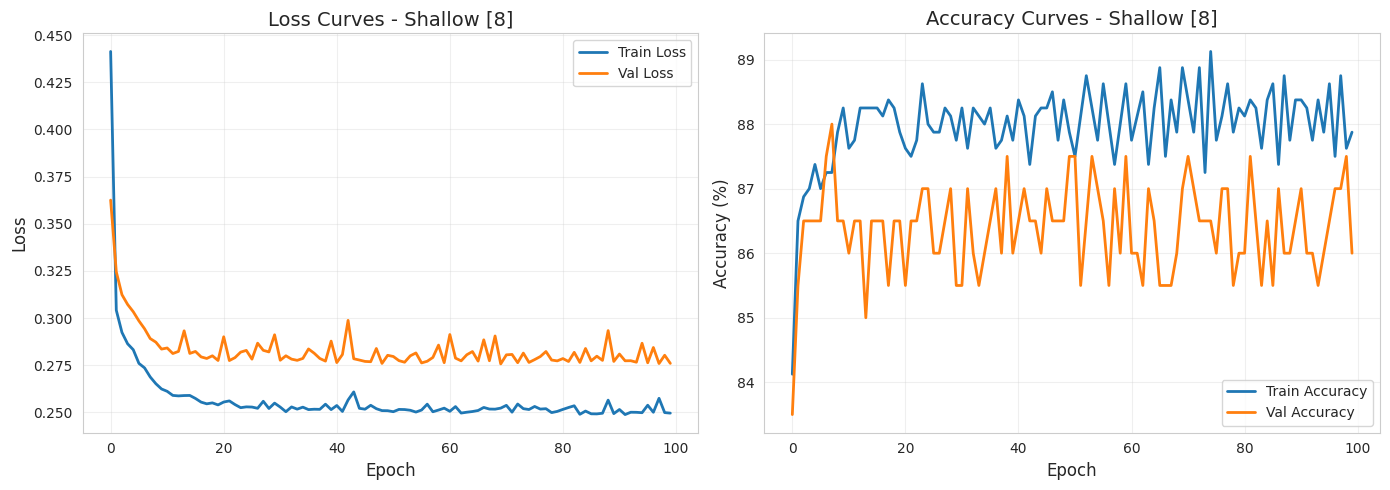

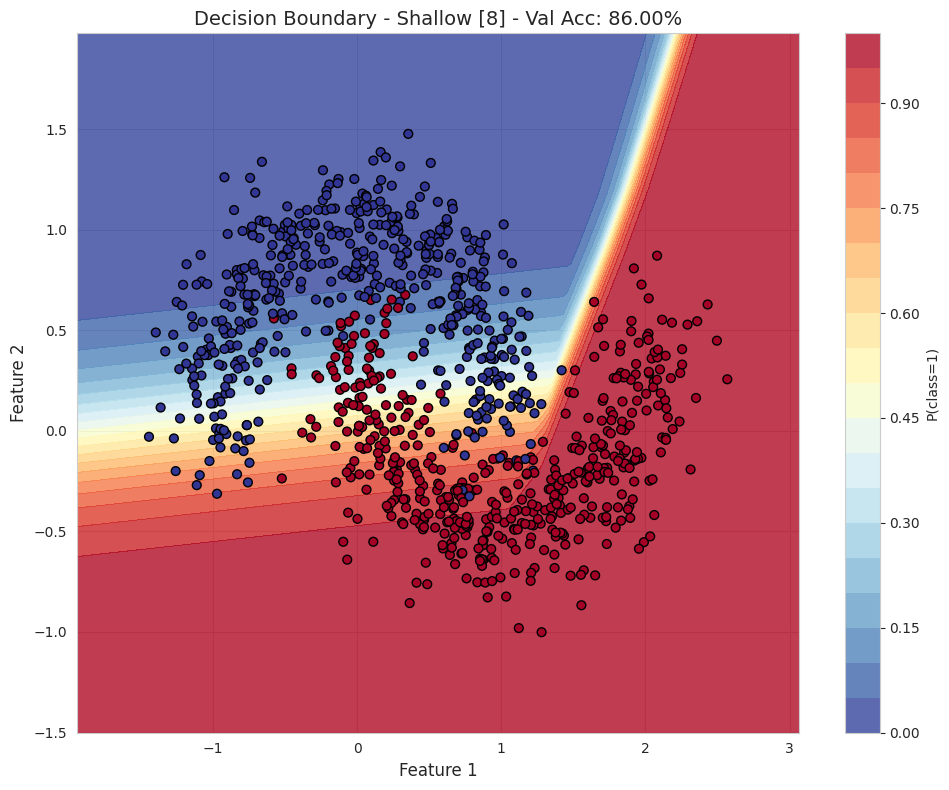

Final Validation Accuracy: 86.00%

--- Training shallow network with 16 neurons ---
Epoch [20/100] - Train Loss: 0.0886, Val Loss: 0.0768, Val Acc: 97.00%
Epoch [40/100] - Train Loss: 0.0764, Val Loss: 0.0515, Val Acc: 98.00%
Epoch [60/100] - Train Loss: 0.0725, Val Loss: 0.0483, Val Acc: 98.50%
Epoch [80/100] - Train Loss: 0.0680, Val Loss: 0.0383, Val Acc: 98.50%
Epoch [100/100] - Train Loss: 0.0647, Val Loss: 0.0463, Val Acc: 98.50%


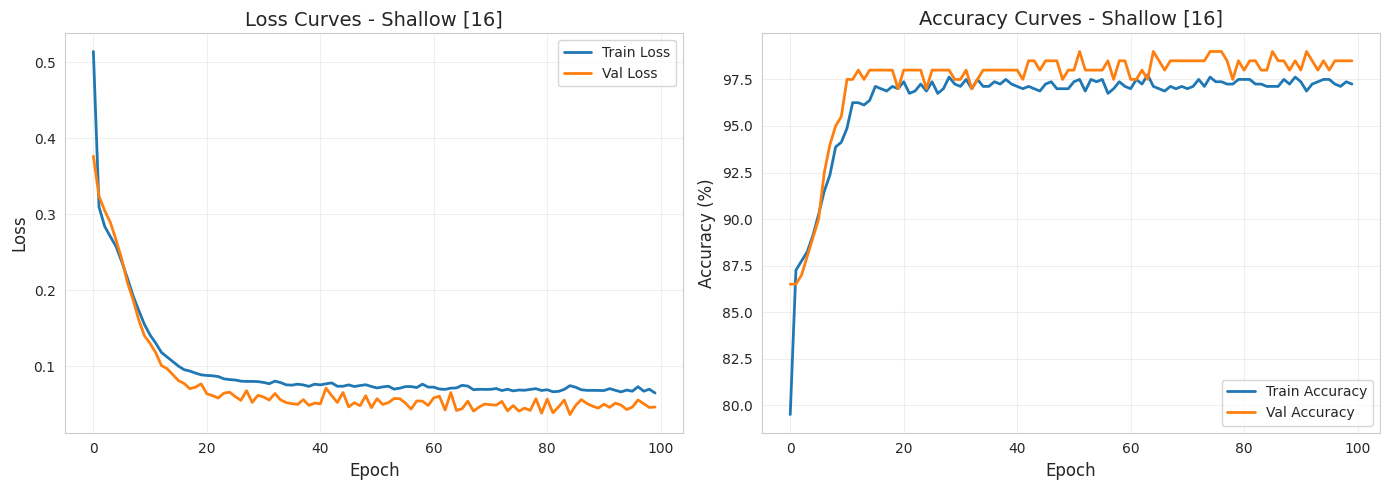

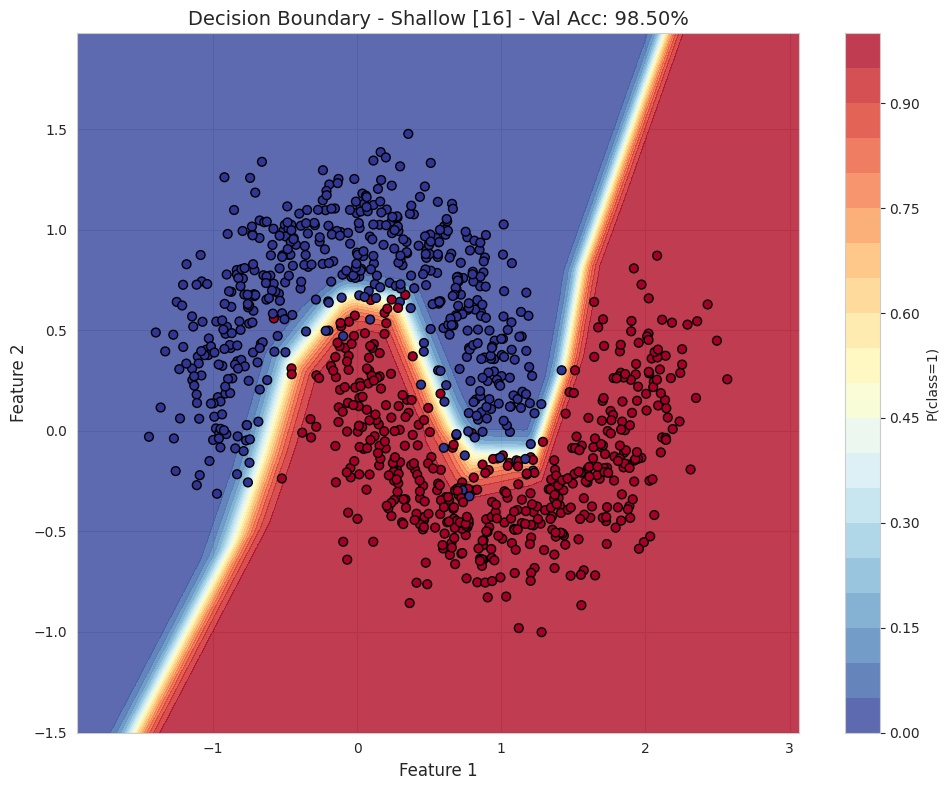

Final Validation Accuracy: 98.50%

--- Training shallow network with 32 neurons ---
Epoch [20/100] - Train Loss: 0.0783, Val Loss: 0.0528, Val Acc: 98.00%
Epoch [40/100] - Train Loss: 0.0689, Val Loss: 0.0580, Val Acc: 97.50%
Epoch [60/100] - Train Loss: 0.0810, Val Loss: 0.0544, Val Acc: 98.00%
Epoch [80/100] - Train Loss: 0.0701, Val Loss: 0.0540, Val Acc: 98.50%
Epoch [100/100] - Train Loss: 0.0673, Val Loss: 0.0485, Val Acc: 99.00%


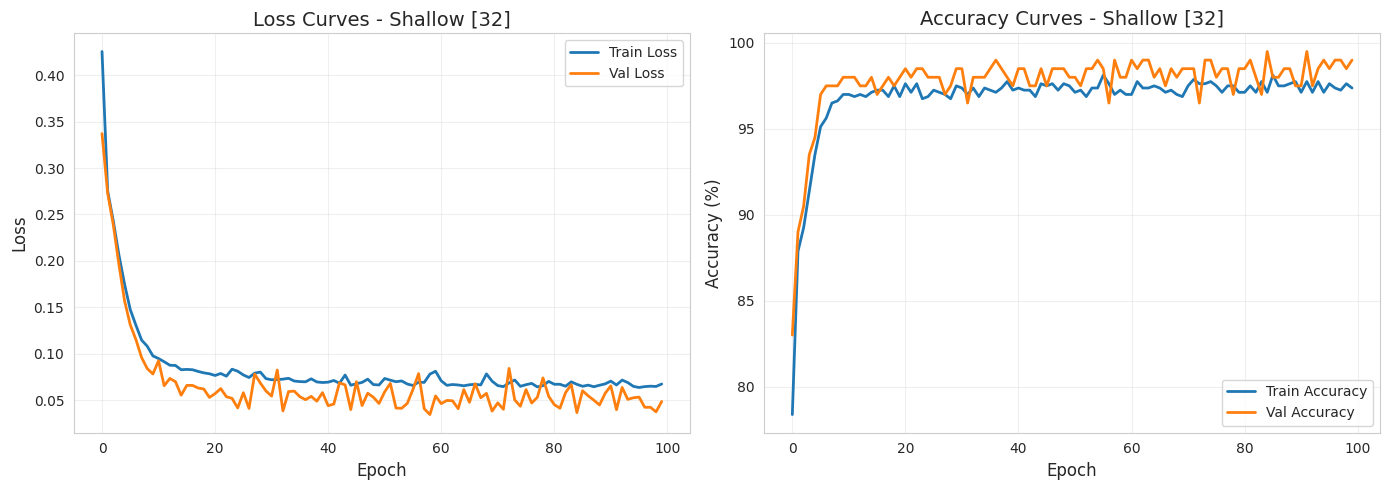

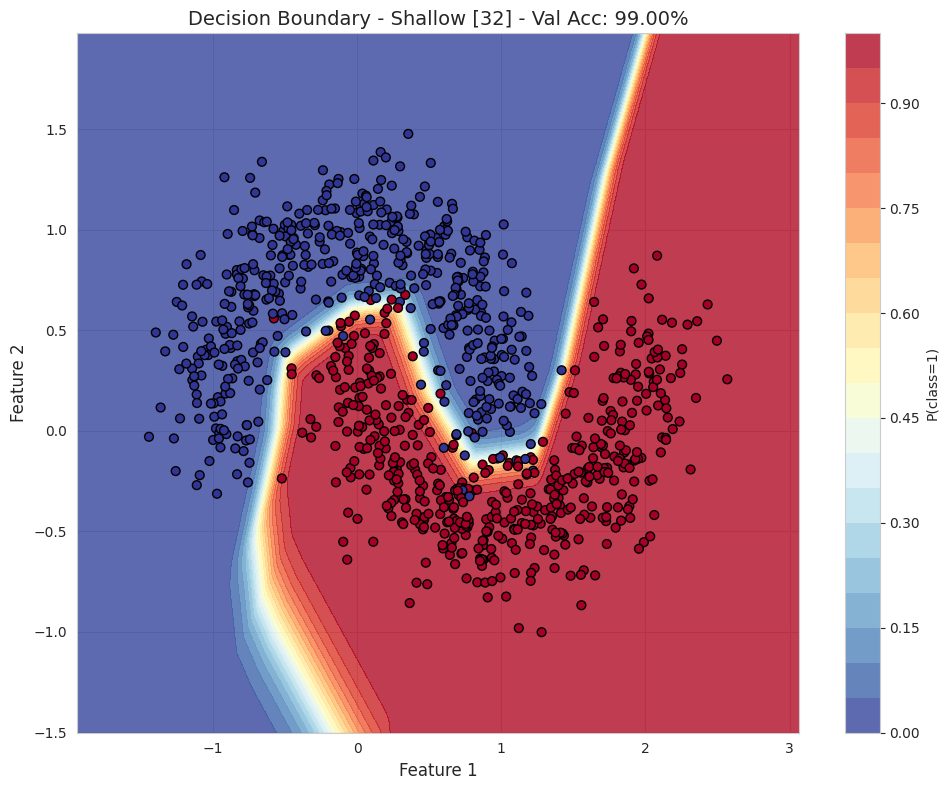

Final Validation Accuracy: 99.00%

--- Training shallow network with 64 neurons ---
Epoch [20/100] - Train Loss: 0.0781, Val Loss: 0.0603, Val Acc: 97.50%
Epoch [40/100] - Train Loss: 0.0674, Val Loss: 0.0539, Val Acc: 98.50%
Epoch [60/100] - Train Loss: 0.0670, Val Loss: 0.0490, Val Acc: 99.00%
Epoch [80/100] - Train Loss: 0.0631, Val Loss: 0.0848, Val Acc: 96.50%
Epoch [100/100] - Train Loss: 0.0685, Val Loss: 0.0376, Val Acc: 98.50%


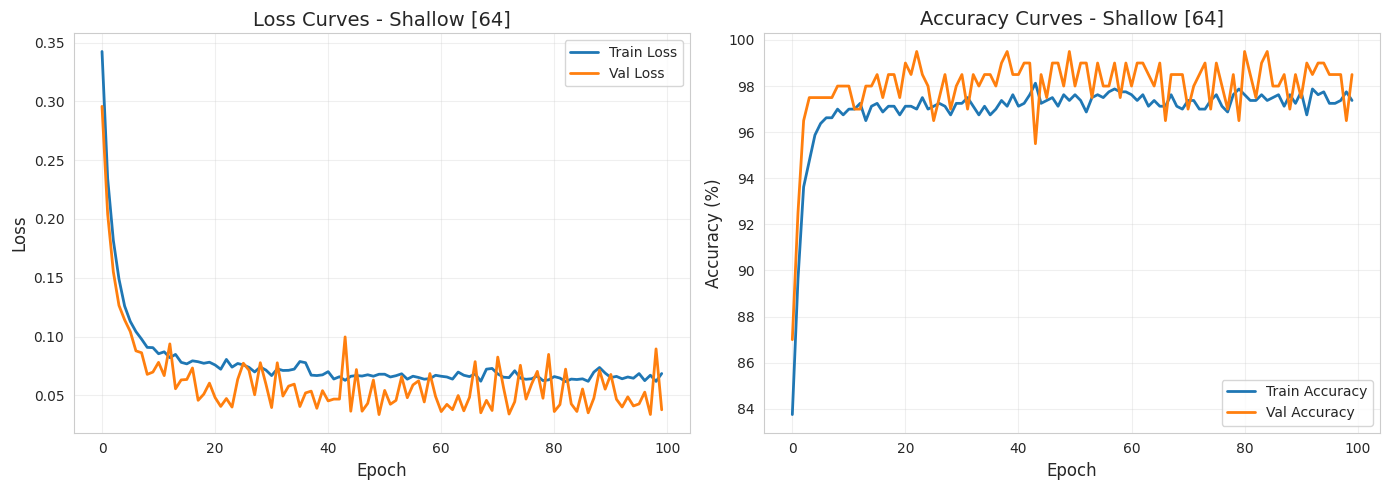

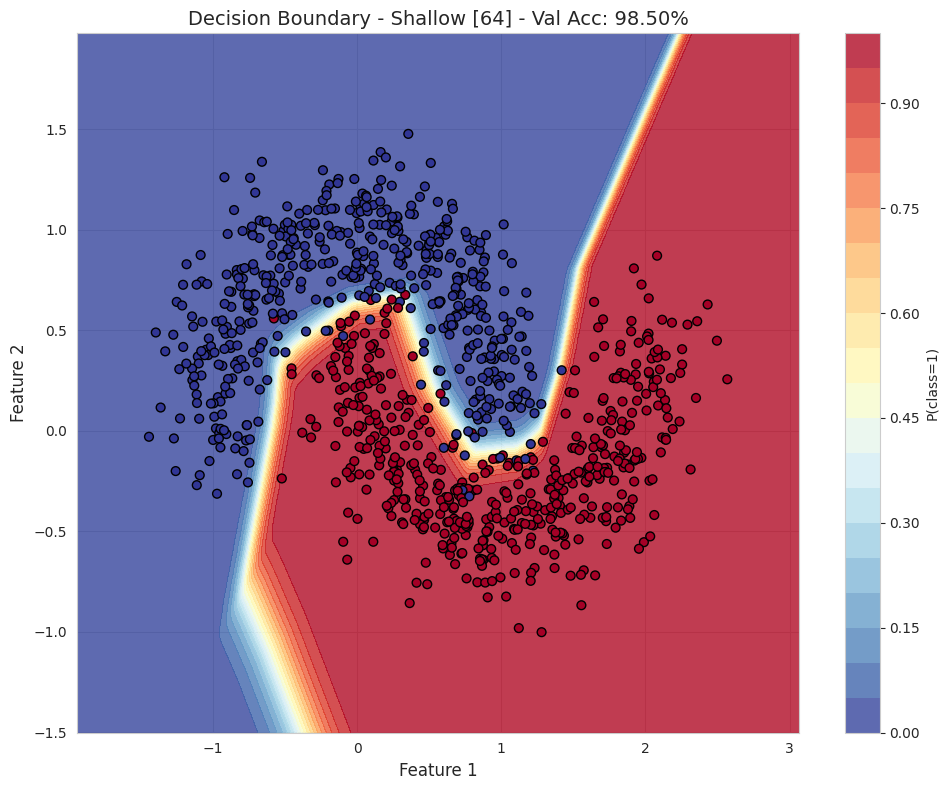

Final Validation Accuracy: 98.50%

--- Training shallow network with 128 neurons ---
Epoch [20/100] - Train Loss: 0.0778, Val Loss: 0.0504, Val Acc: 98.50%
Epoch [40/100] - Train Loss: 0.0757, Val Loss: 0.0608, Val Acc: 98.50%
Epoch [60/100] - Train Loss: 0.0685, Val Loss: 0.0510, Val Acc: 98.50%
Epoch [80/100] - Train Loss: 0.0646, Val Loss: 0.0570, Val Acc: 98.00%
Epoch [100/100] - Train Loss: 0.0688, Val Loss: 0.0570, Val Acc: 97.50%


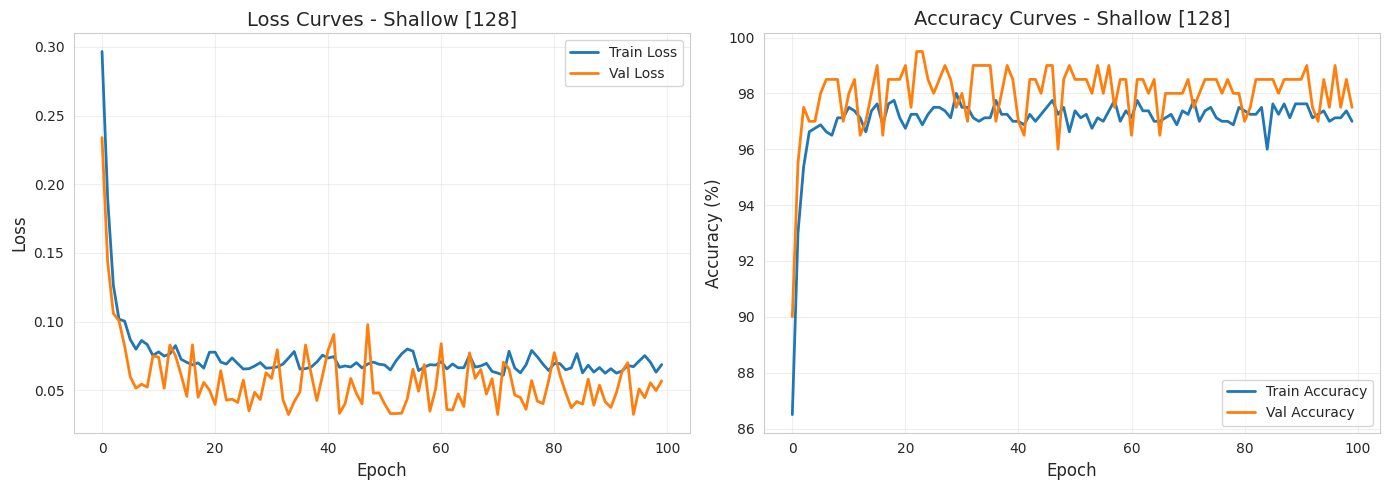

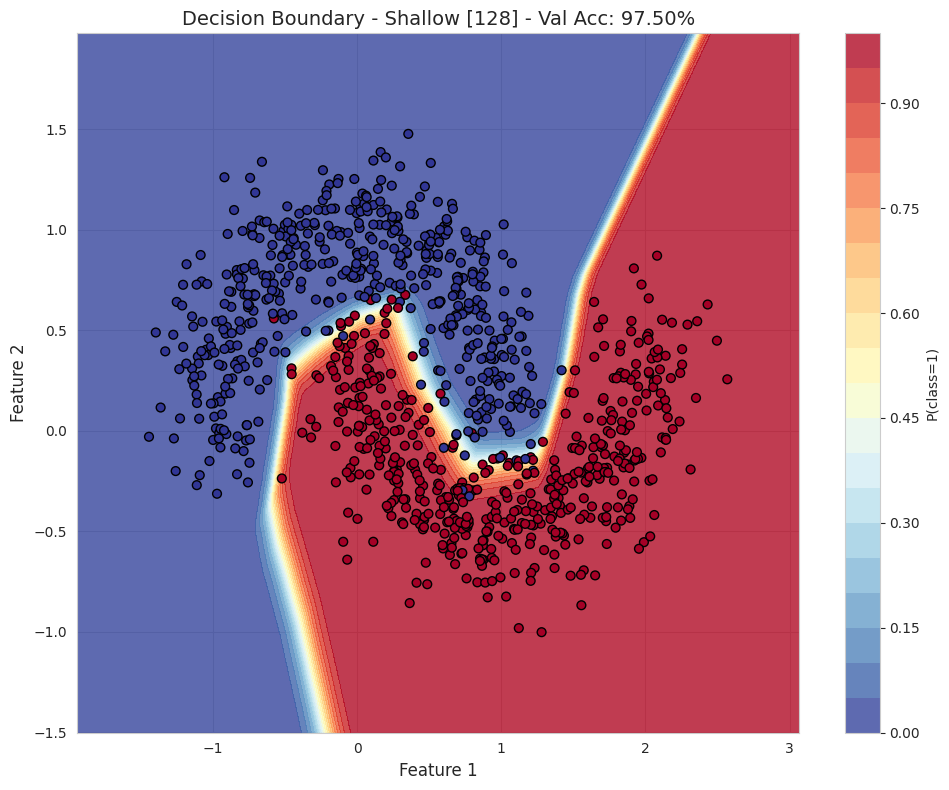

Final Validation Accuracy: 97.50%

--- Training shallow network with 256 neurons ---
Epoch [20/100] - Train Loss: 0.0788, Val Loss: 0.0497, Val Acc: 99.00%
Epoch [40/100] - Train Loss: 0.0685, Val Loss: 0.0584, Val Acc: 98.00%
Epoch [60/100] - Train Loss: 0.0641, Val Loss: 0.0385, Val Acc: 98.50%
Epoch [80/100] - Train Loss: 0.0682, Val Loss: 0.0433, Val Acc: 99.00%
Epoch [100/100] - Train Loss: 0.0666, Val Loss: 0.0641, Val Acc: 97.00%


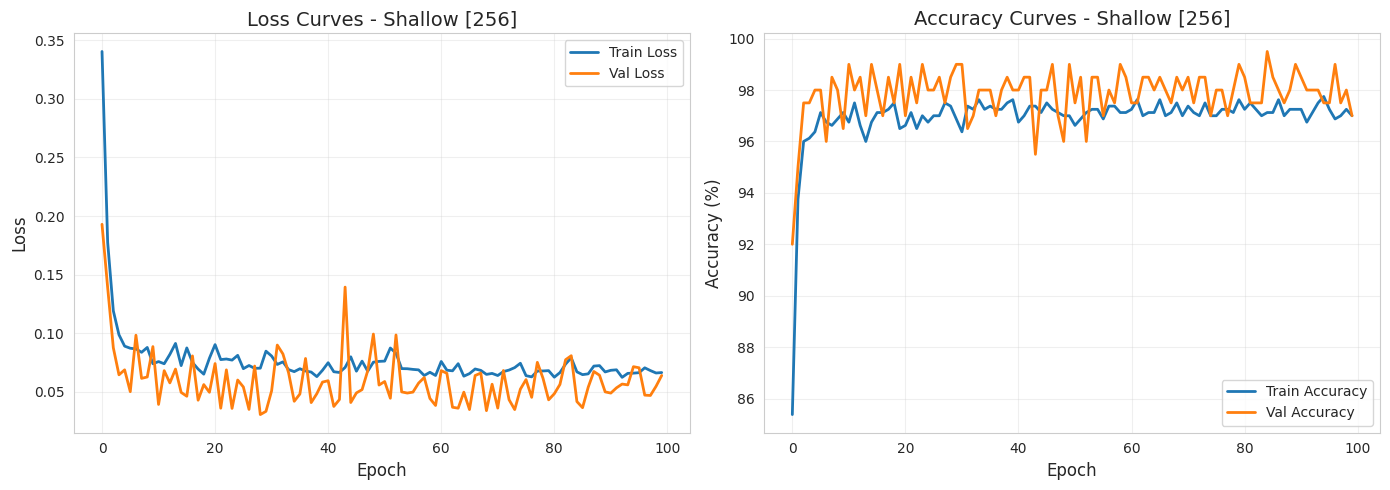

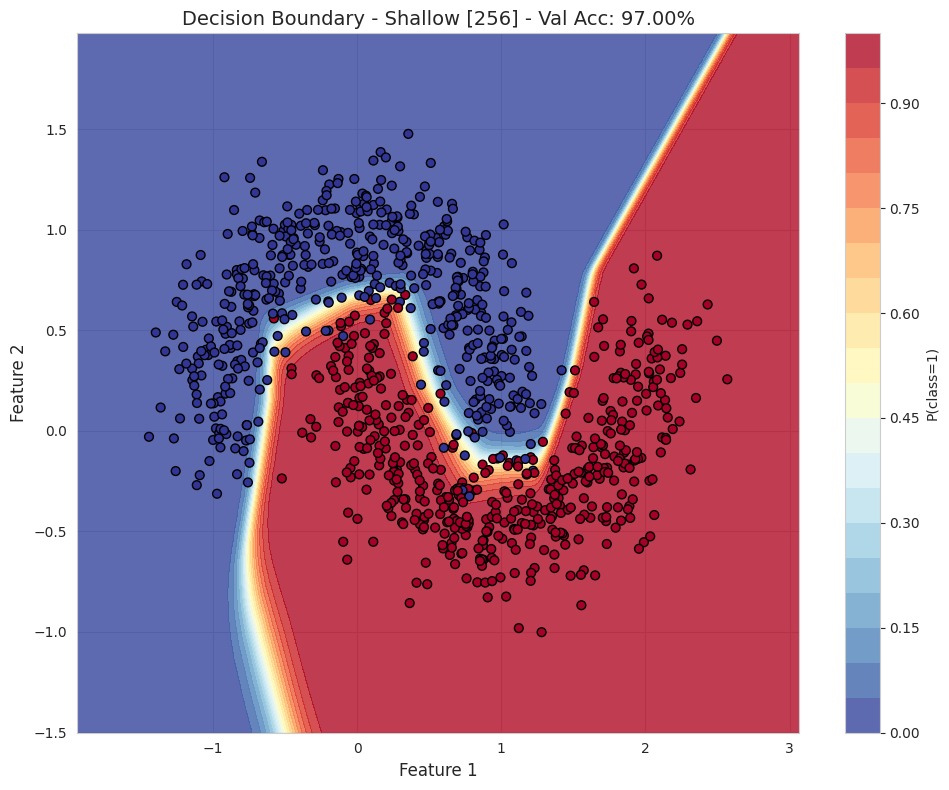

Final Validation Accuracy: 97.00%


In [7]:
# TASK 1: SHALLOW NETWORKS
# Prepare data
X, y, train_loader, val_loader, scaler = prepare_moon_data()

# Visualize dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu_r', edgecolor='k', s=40)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Moon Dataset', fontsize=14)
plt.colorbar(label='Class')
plt.tight_layout()
plt.show()

# Test different hidden sizes
hidden_sizes_list = [8, 16, 32, 64, 128, 256]
results_shallow = {}

for hidden_size in hidden_sizes_list:
    print(f"\n--- Training shallow network with {hidden_size} neurons ---")
    model = MLP(input_size=2, hidden_sizes=[hidden_size], output_size=2, activation='relu')
    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, epochs=100, lr=0.01, device=device
    )
    results_shallow[hidden_size] = {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'final_val_acc': val_accs[-1]
    }

    # Plot results
    plot_training_history(train_losses, val_losses, train_accs, val_accs,
                         title=f"Shallow [{hidden_size}]")
    plot_decision_boundary(model, scaler, X, y,
                          title=f"Shallow [{hidden_size}] - Val Acc: {val_accs[-1]:.2f}%",
                          device=device)

    print(f"Final Validation Accuracy: {val_accs[-1]:.2f}%")



--- Training deep network [64] ---
Epoch [20/100] - Train Loss: 0.0777, Val Loss: 0.0700, Val Acc: 97.50%
Epoch [40/100] - Train Loss: 0.0688, Val Loss: 0.0559, Val Acc: 98.00%
Epoch [60/100] - Train Loss: 0.0663, Val Loss: 0.0506, Val Acc: 99.00%
Epoch [80/100] - Train Loss: 0.0720, Val Loss: 0.0299, Val Acc: 98.50%
Epoch [100/100] - Train Loss: 0.0621, Val Loss: 0.0501, Val Acc: 98.00%


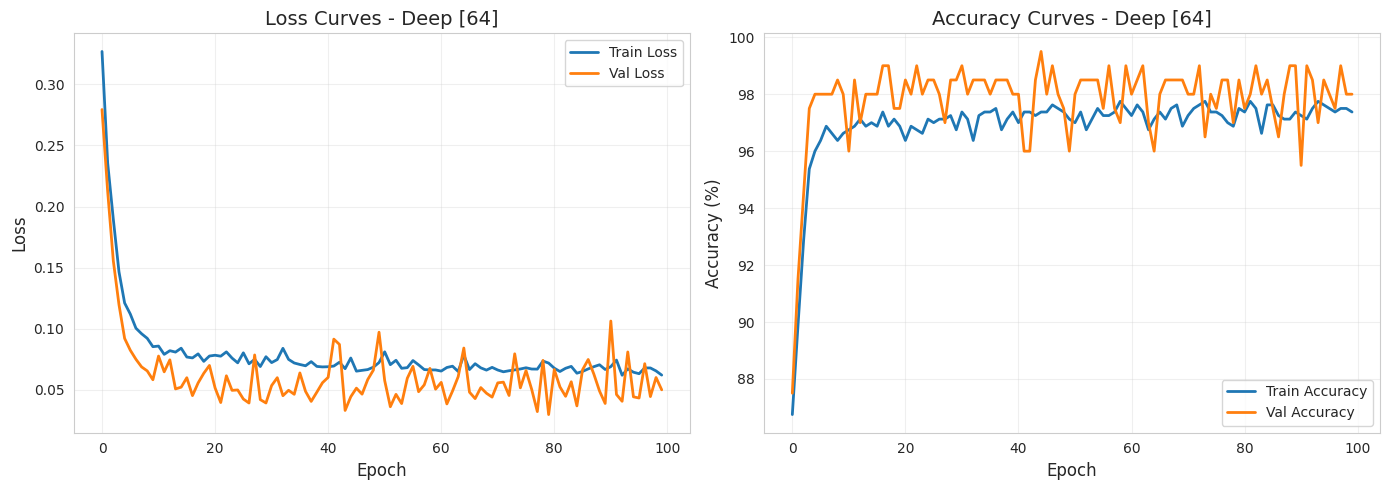

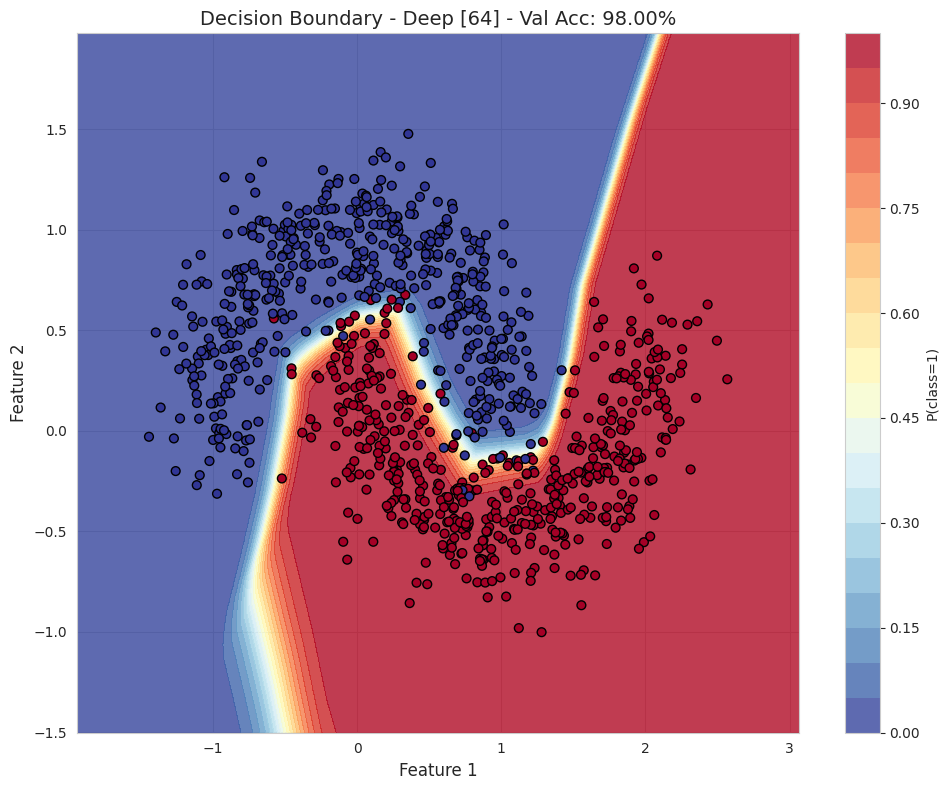

Final Validation Accuracy: 98.00%

--- Training deep network [32, 32] ---
Epoch [20/100] - Train Loss: 0.0708, Val Loss: 0.0428, Val Acc: 98.50%
Epoch [40/100] - Train Loss: 0.0638, Val Loss: 0.0390, Val Acc: 98.50%
Epoch [60/100] - Train Loss: 0.0596, Val Loss: 0.0657, Val Acc: 98.00%
Epoch [80/100] - Train Loss: 0.0620, Val Loss: 0.0675, Val Acc: 98.00%
Epoch [100/100] - Train Loss: 0.0634, Val Loss: 0.0417, Val Acc: 98.00%


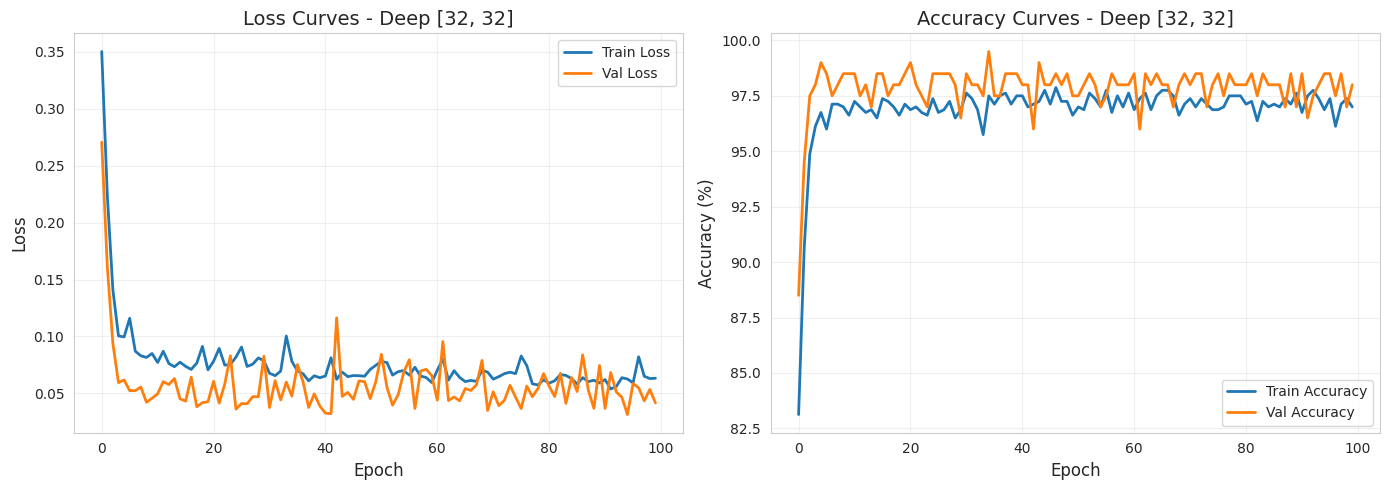

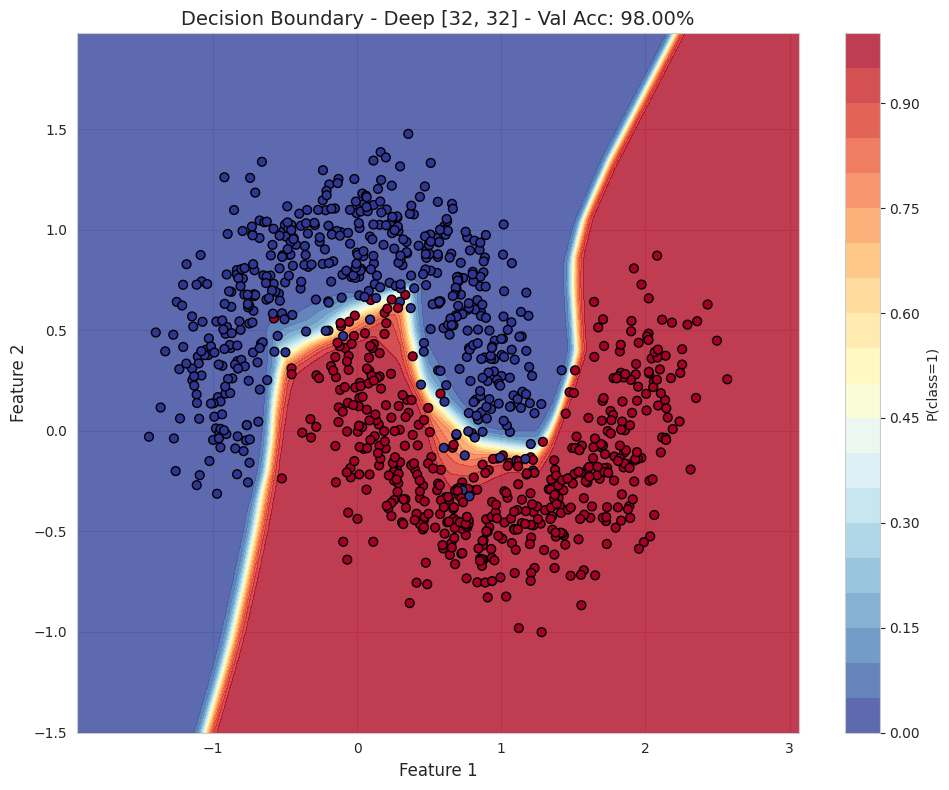

Final Validation Accuracy: 98.00%

--- Training deep network [64, 32, 16] ---
Epoch [20/100] - Train Loss: 0.0715, Val Loss: 0.0438, Val Acc: 98.50%
Epoch [40/100] - Train Loss: 0.0657, Val Loss: 0.0345, Val Acc: 98.00%
Epoch [60/100] - Train Loss: 0.0636, Val Loss: 0.0456, Val Acc: 98.00%
Epoch [80/100] - Train Loss: 0.0538, Val Loss: 0.0502, Val Acc: 97.50%
Epoch [100/100] - Train Loss: 0.0600, Val Loss: 0.0624, Val Acc: 97.50%


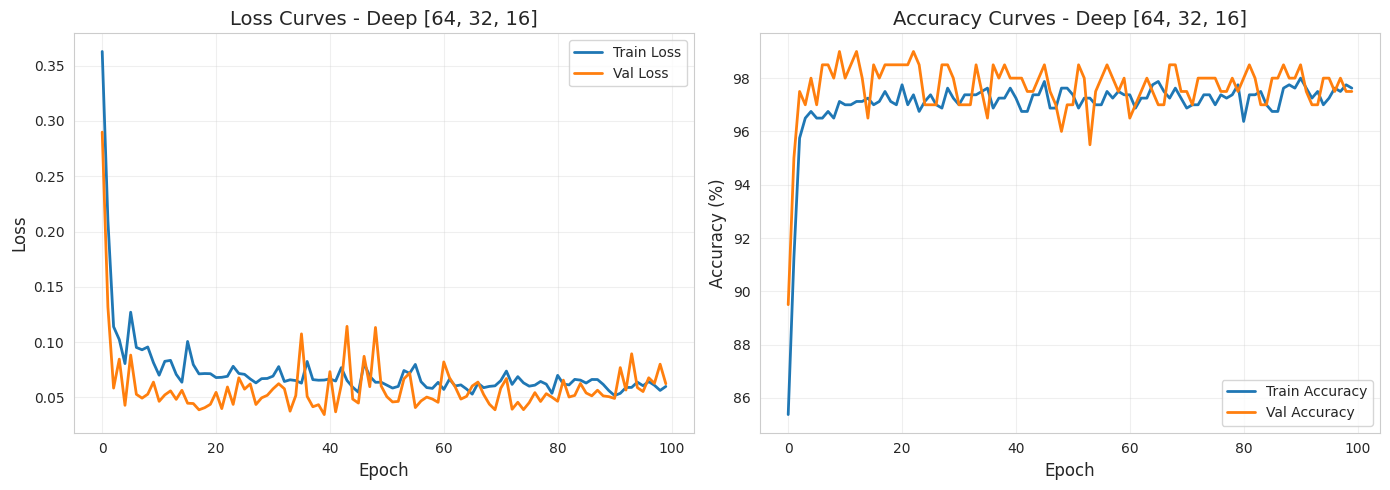

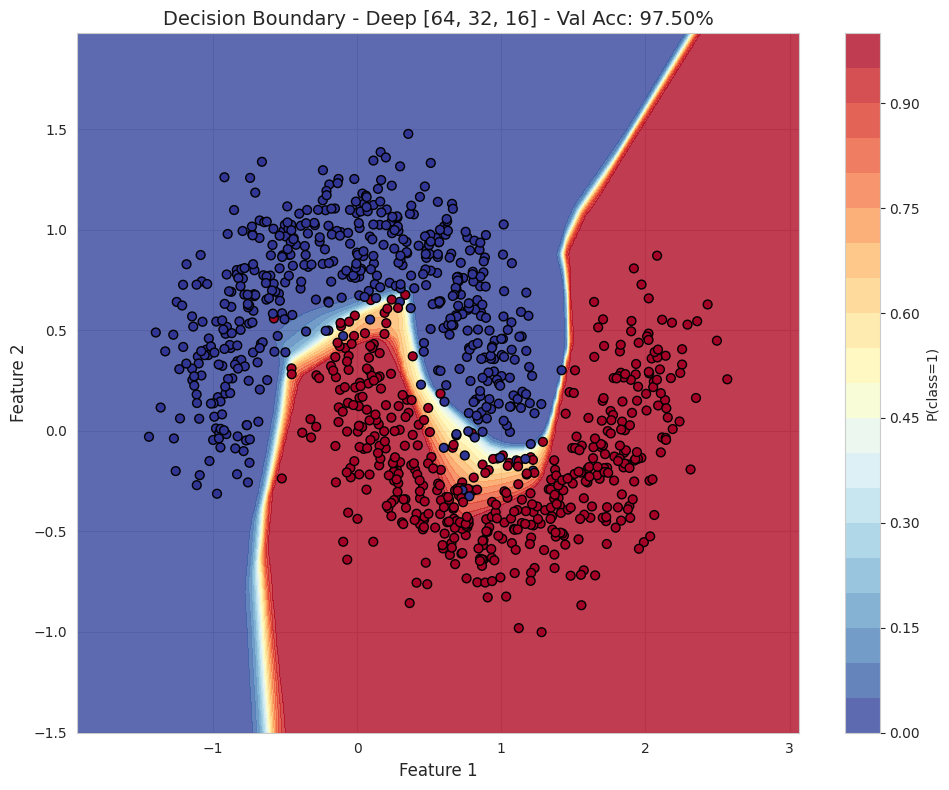

Final Validation Accuracy: 97.50%

--- Training deep network [128, 64, 32, 16] ---
Epoch [20/100] - Train Loss: 0.0856, Val Loss: 0.0700, Val Acc: 98.50%
Epoch [40/100] - Train Loss: 0.0657, Val Loss: 0.0483, Val Acc: 98.50%
Epoch [60/100] - Train Loss: 0.0627, Val Loss: 0.0421, Val Acc: 98.00%
Epoch [80/100] - Train Loss: 0.0613, Val Loss: 0.0521, Val Acc: 97.50%
Epoch [100/100] - Train Loss: 0.0638, Val Loss: 0.0988, Val Acc: 97.50%


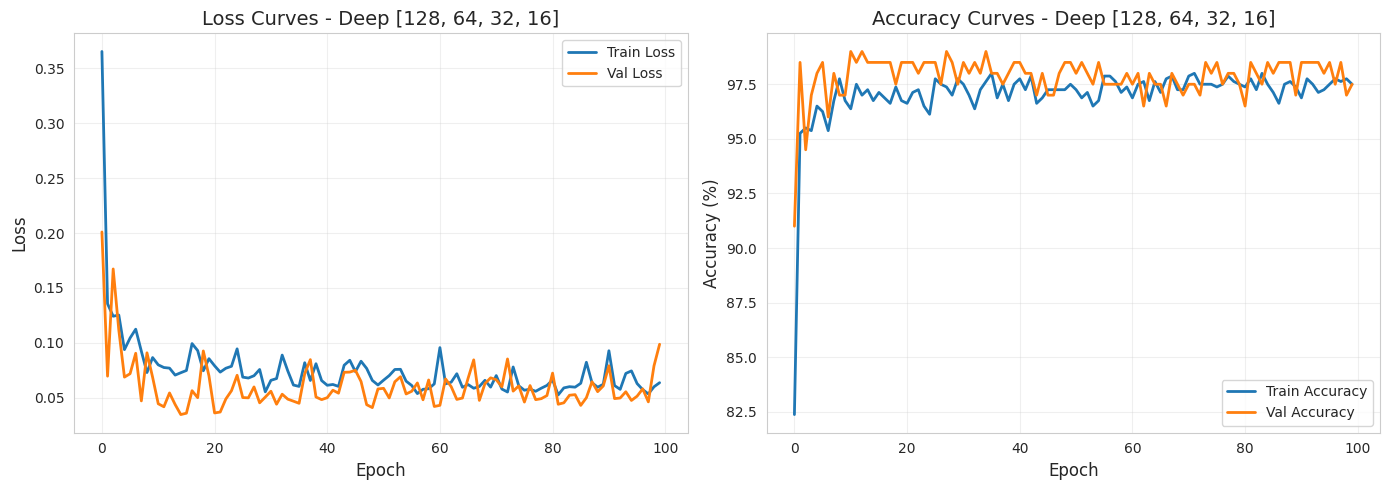

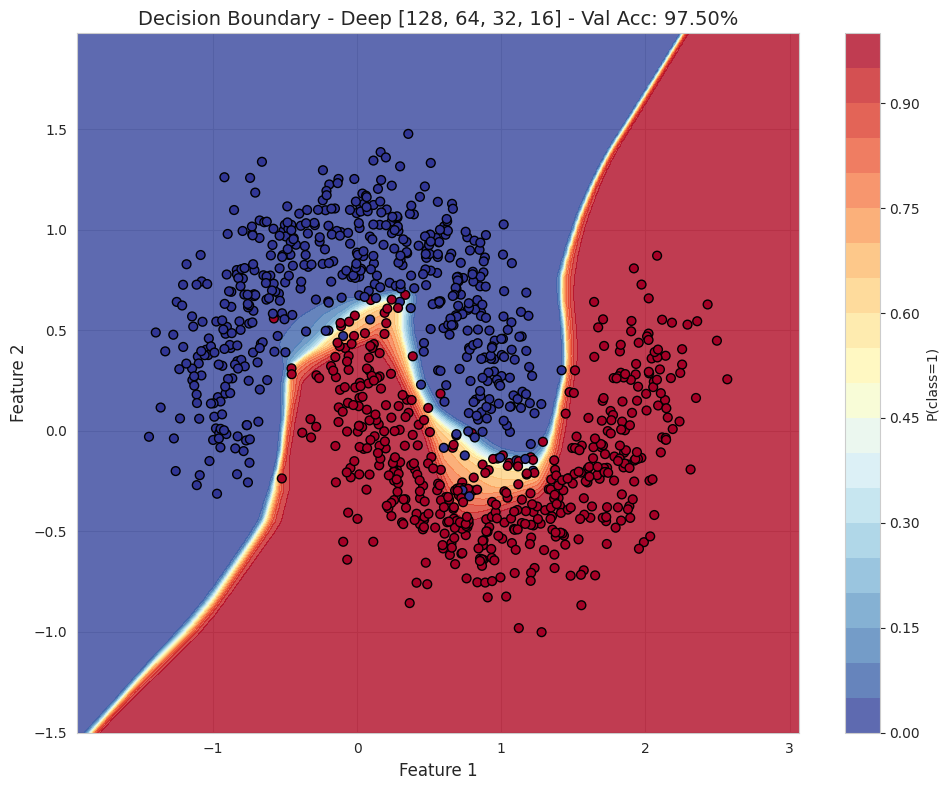

Final Validation Accuracy: 97.50%

--- Training deep network [256, 128, 64, 32] ---
Epoch [20/100] - Train Loss: 0.0665, Val Loss: 0.0490, Val Acc: 97.50%
Epoch [40/100] - Train Loss: 0.0693, Val Loss: 0.0394, Val Acc: 98.00%
Epoch [60/100] - Train Loss: 0.0548, Val Loss: 0.0578, Val Acc: 98.00%
Epoch [80/100] - Train Loss: 0.0583, Val Loss: 0.0580, Val Acc: 98.00%
Epoch [100/100] - Train Loss: 0.0628, Val Loss: 0.0689, Val Acc: 98.00%


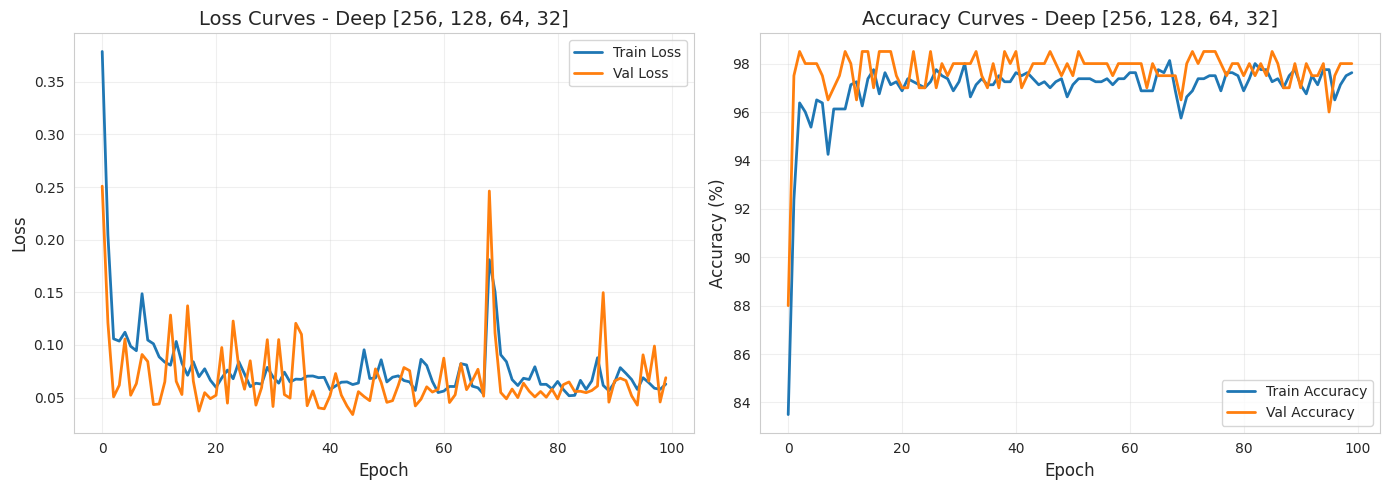

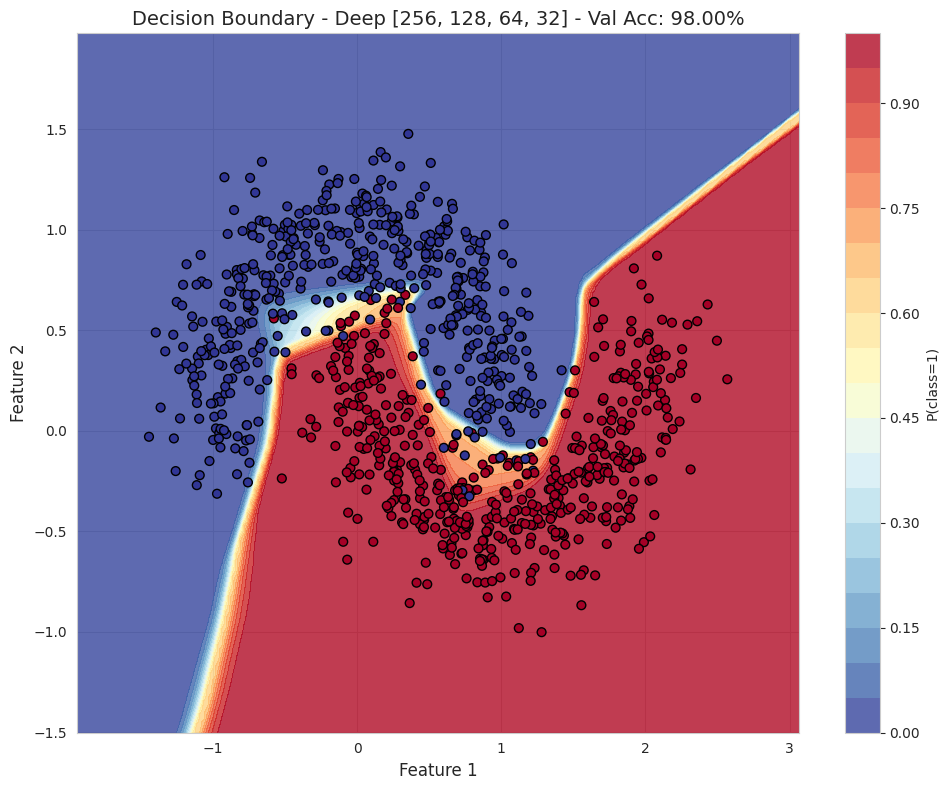

Final Validation Accuracy: 98.00%

--- Testing with Batch Normalization ---
Epoch [20/100] - Train Loss: 0.1671, Val Loss: 0.0746, Val Acc: 97.00%
Epoch [40/100] - Train Loss: 0.1626, Val Loss: 0.0635, Val Acc: 98.50%
Epoch [60/100] - Train Loss: 0.1224, Val Loss: 0.0594, Val Acc: 97.50%
Epoch [80/100] - Train Loss: 0.1016, Val Loss: 0.0773, Val Acc: 97.00%
Epoch [100/100] - Train Loss: 0.1037, Val Loss: 0.0795, Val Acc: 97.00%


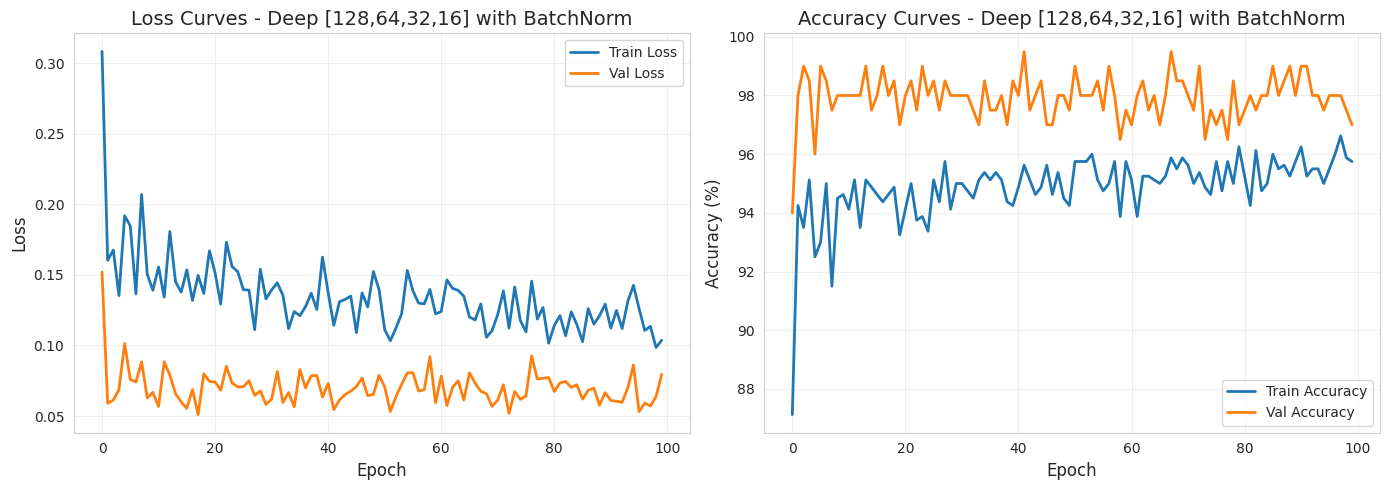

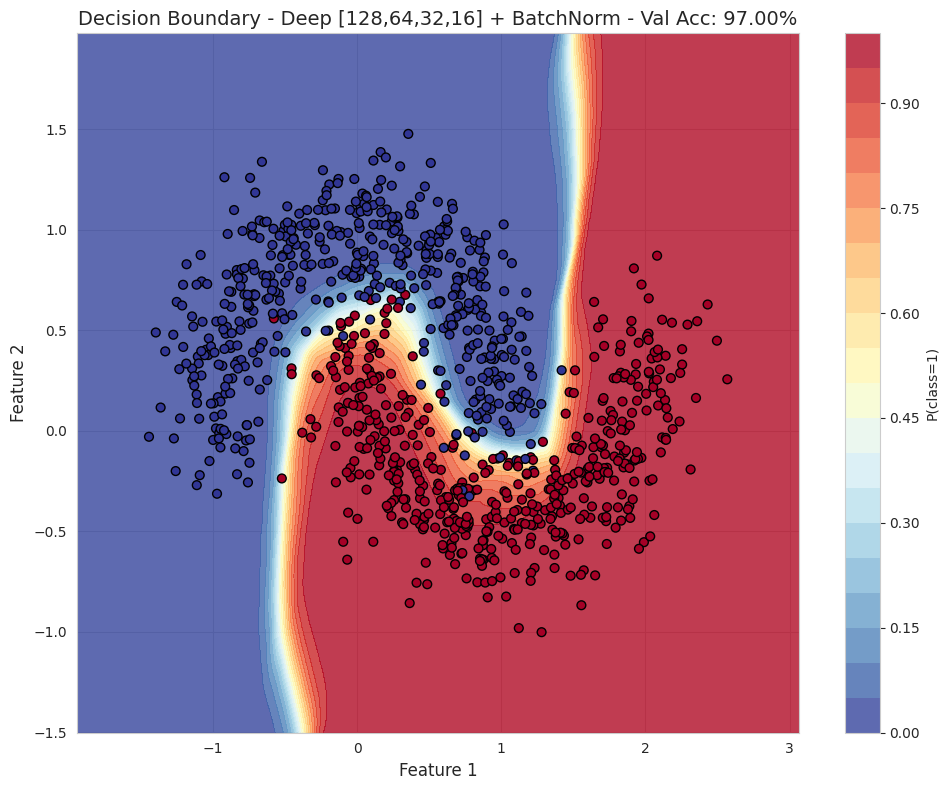

In [8]:
# TASK 2: DEEPER NETWORKS
# Test different architectures
architectures = [
    [64],
    [32, 32],
    [64, 32, 16],
    [128, 64, 32, 16],
    [256, 128, 64, 32]
]

results_deep = {}

for arch in architectures:
    arch_str = str(arch)
    print(f"\n--- Training deep network {arch_str} ---")

    # Without batch normalization
    model = MLP(input_size=2, hidden_sizes=arch, output_size=2,
                activation='relu', use_batchnorm=False)
    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, epochs=100, lr=0.01, device=device
    )

    results_deep[arch_str] = {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'final_val_acc': val_accs[-1]
    }

    plot_training_history(train_losses, val_losses, train_accs, val_accs,
                         title=f"Deep {arch_str}")
    plot_decision_boundary(model, scaler, X, y,
                          title=f"Deep {arch_str} - Val Acc: {val_accs[-1]:.2f}%",
                          device=device)

    print(f"Final Validation Accuracy: {val_accs[-1]:.2f}%")

# Test with Batch Normalization
print("\n--- Testing with Batch Normalization ---")
model_bn = MLP(input_size=2, hidden_sizes=[128, 64, 32, 16], output_size=2,
               activation='relu', use_batchnorm=True)
train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = train_model(
    model_bn, train_loader, val_loader, epochs=100, lr=0.01, device=device
)

plot_training_history(train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn,
                     title="Deep [128,64,32,16] with BatchNorm")
plot_decision_boundary(model_bn, scaler, X, y,
                      title=f"Deep [128,64,32,16] + BatchNorm - Val Acc: {val_accs_bn[-1]:.2f}%",
                      device=device)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.21MB/s]


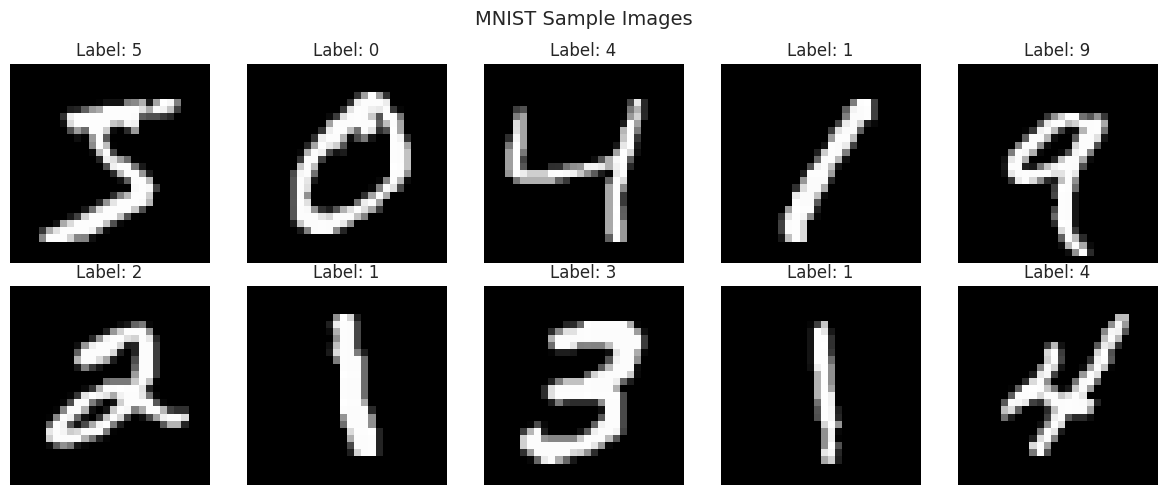


--- Training MNIST network [512] ---


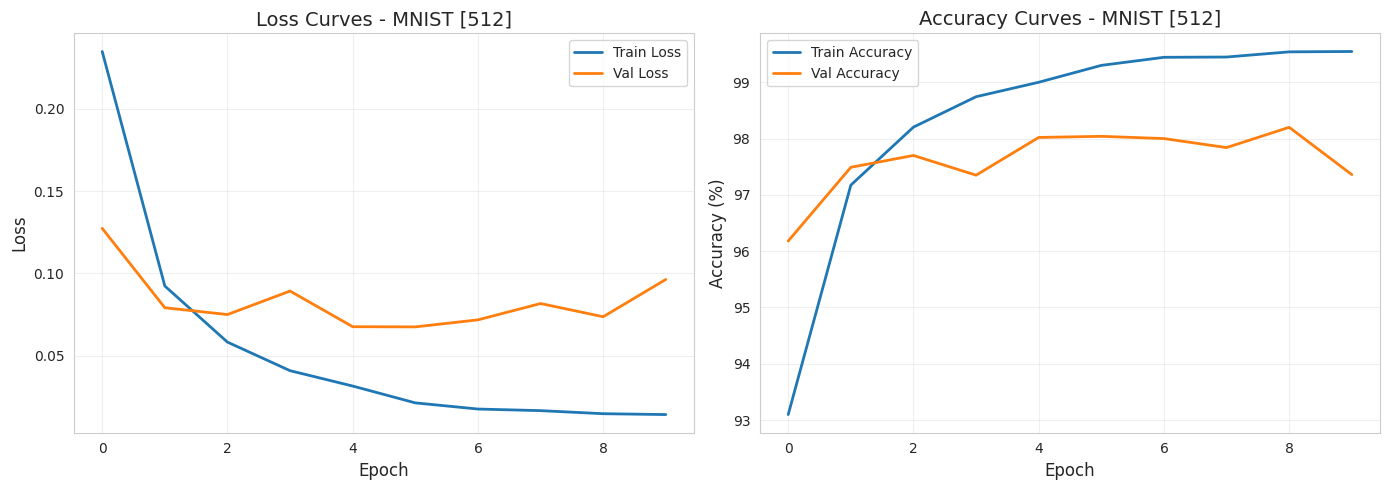

Final Test Accuracy: 97.36%

--- Training MNIST network [256, 128] ---


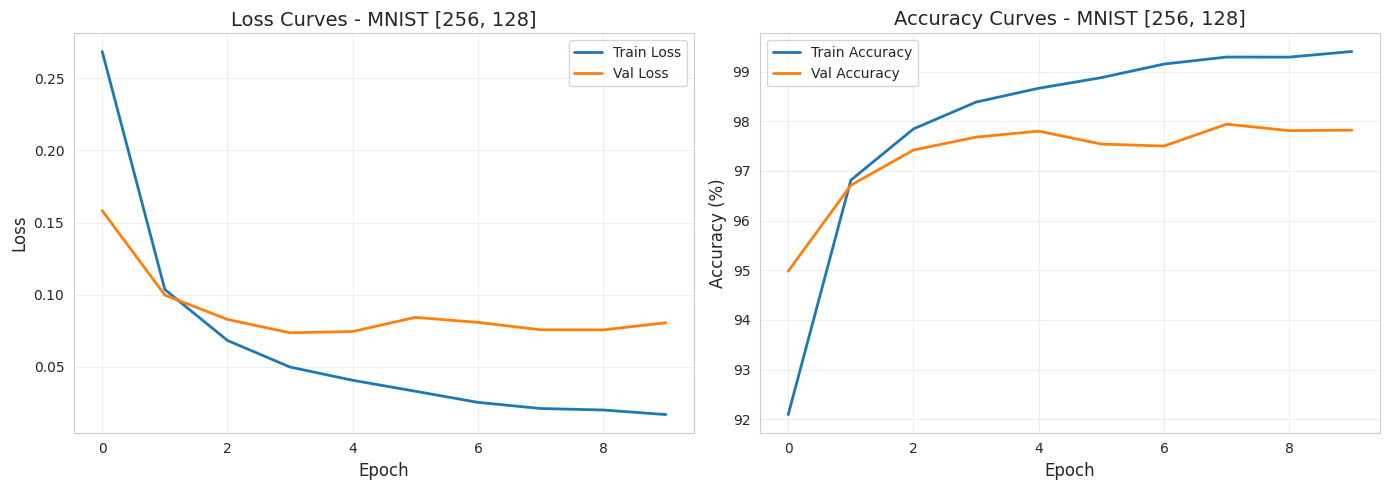

Final Test Accuracy: 97.82%

--- Training MNIST network [512, 256, 128] ---


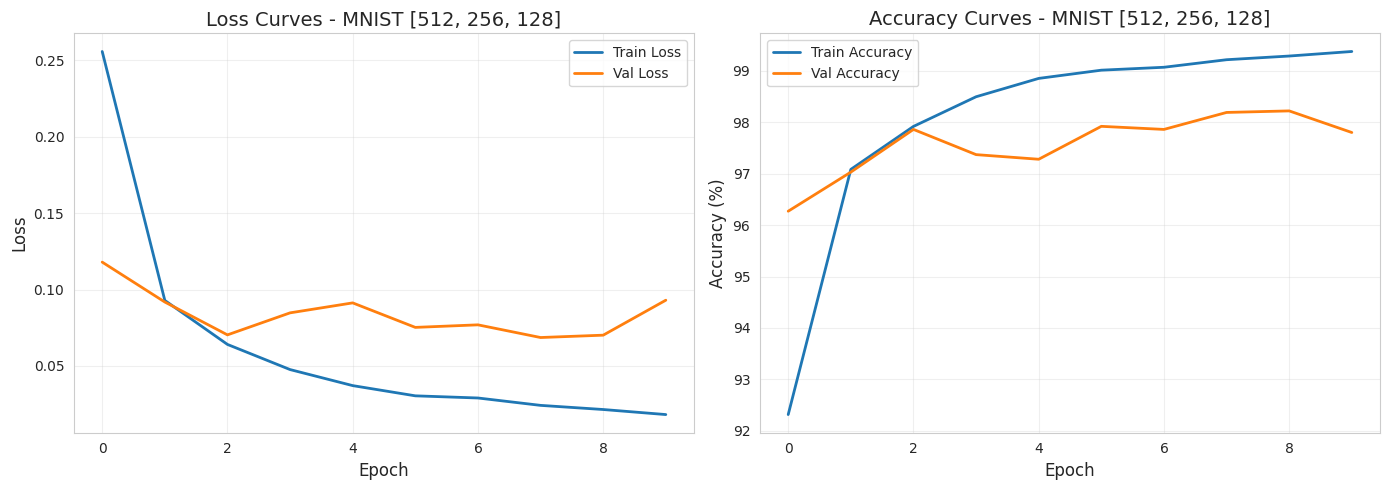

Final Test Accuracy: 97.80%

--- Training MNIST network [256, 128, 64] ---


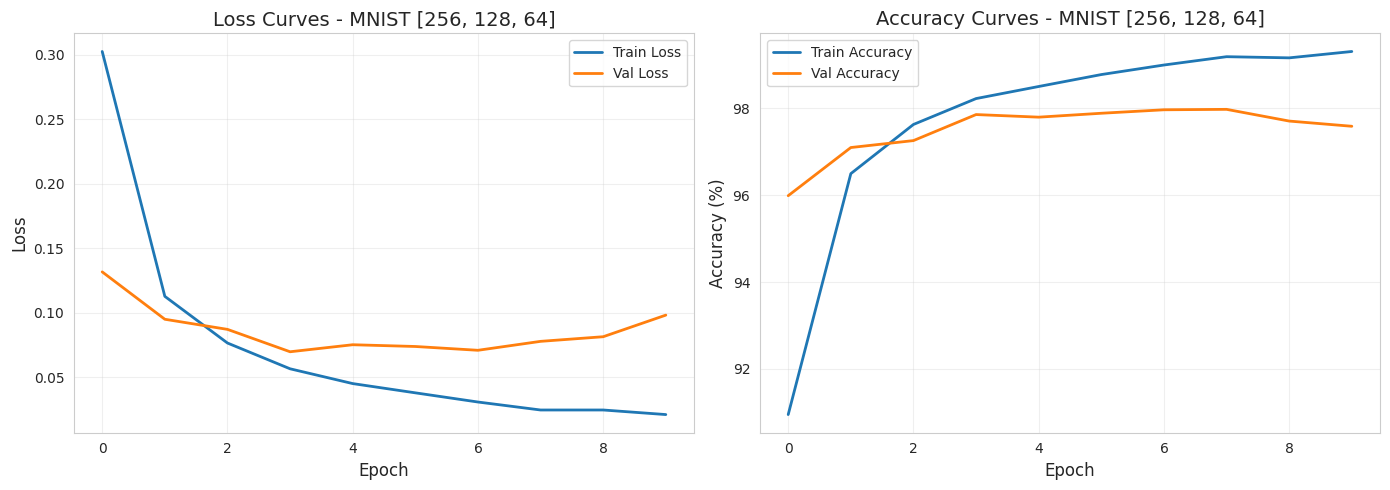

Final Test Accuracy: 97.59%


In [9]:
# TASK 3: MNIST CLASSIFICATION
# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader_mnist = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader_mnist = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.suptitle('MNIST Sample Images', fontsize=14)
plt.tight_layout()
plt.show()

# Define MNIST MLP wrapper
class MNIST_MLP(nn.Module):
    def __init__(self, hidden_sizes, use_batchnorm=False):
        super(MNIST_MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.mlp = MLP(784, hidden_sizes, 10, activation='relu', use_batchnorm=use_batchnorm)

    def forward(self, x):
        x = self.flatten(x)
        return self.mlp(x)

# Test different architectures
mnist_architectures = [
    [512],
    [256, 128],
    [512, 256, 128],
    [256, 128, 64]
]

results_mnist = {}

for arch in mnist_architectures:
    arch_str = str(arch)
    print(f"\n--- Training MNIST network {arch_str} ---")

    model = MNIST_MLP(arch).to(device)
    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader_mnist, test_loader_mnist, epochs=10, lr=0.001, device=device
    )

    results_mnist[arch_str] = {
        'model': model,
        'final_test_acc': val_accs[-1]
    }

    plot_training_history(train_losses, val_losses, train_accs, val_accs,
                         title=f"MNIST {arch_str}")

    print(f"Final Test Accuracy: {val_accs[-1]:.2f}%")

In [10]:
# SUMMARY COMPARISON
print("\n" + "=" * 60)
print("RESULTS SUMMARY")
print("=" * 60)

print("\nTask 1 - Shallow Networks:")
for size, result in results_shallow.items():
    print(f"  [{size}]: {result['final_val_acc']:.2f}%")

print("\nTask 2 - Deep Networks:")
for arch, result in results_deep.items():
    print(f"  {arch}: {result['final_val_acc']:.2f}%")

print("\nTask 3 - MNIST:")
for arch, result in results_mnist.items():
    print(f"  {arch}: {result['final_test_acc']:.2f}%")


RESULTS SUMMARY

Task 1 - Shallow Networks:
  [8]: 86.00%
  [16]: 98.50%
  [32]: 99.00%
  [64]: 98.50%
  [128]: 97.50%
  [256]: 97.00%

Task 2 - Deep Networks:
  [64]: 98.00%
  [32, 32]: 98.00%
  [64, 32, 16]: 97.50%
  [128, 64, 32, 16]: 97.50%
  [256, 128, 64, 32]: 98.00%

Task 3 - MNIST:
  [512]: 97.36%
  [256, 128]: 97.82%
  [512, 256, 128]: 97.80%
  [256, 128, 64]: 97.59%
